In [8]:
# Import necessary libraries
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import json
import os
import seaborn as sns
import openpyxl

# import pymc as pm
# import arviz as az
# import stan
# import aesara.tensor as at
# import nest_asyncio

from scipy.special import ndtri
from scipy.stats import norm, lognorm
from scipy.optimize import minimize

from sklearn.metrics import roc_auc_score

import time

# from utils import stan_wrapper, stan_visualize_out, stan_predict, \
#     pymc_wrapper, pymc_predict, MLS_wrapper, minimize_predict

In [15]:
# MLS model
def MLS_wrapper(df, x0, distro_estimates):
    
    # # Calculate eta (perceived probability of a successful investment due ambiguity).
    # def calc_eta(green, red, theta, prob_ambi=None):
    #     ''' Calculates the eta given prob_win, prob_loss, and ambiguity. theta is estimated.'''
    #     if prob_ambi==None:
    #         return round(green + (1-green-red)*theta,3)
    #     else:
    #         # if prob_ambi+red+green!=1:
    #         #     print(f'Probabilities do not add up to 0: {prob_ambi+red+green}')
    #         return round(green + prob_ambi*theta,3)

    # # Calculate subject probability (using the perceived eta).
    # def calc_subj_prob(prob, gamma=1):
    #     ''' Converts the preceived probabilities to subjective probability. gamma is estimated.'''
    #     return prob**gamma/(prob**gamma + (1-prob)**gamma)**(1/gamma)

    # # Calculating the subjective value of losses and gains. Lambda estimated
    # def calc_subj_values(x, Lambda, alpha, beta):
    #     ''' Calculates the subjective value of gains and losses, given an alpha parameter. Lambda estimate. Alpha could be estimated but used as constant=0.9.'''
    #     if x >= 0:
    #         return x**alpha
    #     else:
    #         return -Lambda*(-x)**beta

    # # Calculating prospect utility.
    # def calc_pt_utility(gain, loss, prob_win, prob_loss, theta, Lambda, alpha, beta, gamma=1, prob_ambi=None):
    #     ''' Calculates the prospect theory utility of investing. Losses are negative numbers and we just add all the outcomes*probabilities.'''
    #     # print(max(0,calc_eta(prob_win, prob_loss, theta, prob_ambi)))
    #     # print(min(max(0,calc_eta(prob_win, prob_loss, theta, prob_ambi)),1))
    #     prob_g = calc_eta(prob_win, prob_loss, theta, prob_ambi).clip(0,1)
    #     prob_l = calc_eta(prob_loss, prob_win, 1-theta, prob_ambi).clip(0,1)
    #     pt_u   = calc_subj_values(gain, Lambda, alpha, beta) * calc_subj_prob(prob_g, gamma=gamma) + calc_subj_values(loss, Lambda, alpha, beta) * calc_subj_prob(prob_l, gamma=gamma)
    #     return pt_u

    # # Calculating the probability to invest.
    # def calc_prob_invest_data(invest,utility,tau,error):
    #     yy = 2*invest-1
    #     return (1)/(1+np.exp(-tau*(utility-error)*yy))

    # # classify whether somebody invests or not.
    # def likelihood_data(invest,gain, loss, prob_win, prob_loss, theta, Lambda, tau, alpha, beta, gamma,error):
    #     ''' Function to determine if someone would invest in the gamble given theta, gamma, lambda, and tau.'''
    #     utility = calc_pt_utility(gain, loss, prob_win, prob_loss, theta, Lambda, alpha, beta, gamma)
    #     probability = calc_prob_invest_data(invest,utility,tau, error)
    #     return probability
    
    
    # def lognormal_pdf(value, mu, sigma):
    #     ''' Function to calculate the lognormal density'''
    #     shape  = sigma
    #     loc    = 0
    #     scale  = np.exp(mu)
    #     return lognorm.pdf(value, shape, loc, scale)

    # def normal_pdf(value, mu, sigma):
    #     ''' Function to calculate the lognormal density'''
    #     loc    = 0
    #     scale  = sigma
    #     return norm.pdf(value, loc, scale)
    
    
    def lognormal_pdf(value, mu, sigma):
        ''' Function to calculate the lognormal density'''
        shape  = sigma
        loc    = 0
        scale  = np.exp(mu)
        return lognorm.pdf(value, shape, loc, scale)

    def normal_pdf(value, mu, sigma):
        ''' Function to calculate the lognormal density'''
        loc    = 0
        scale  = sigma
        return norm.pdf(value, loc, scale)

    ## Functions for calculating the probability
    # Calculate eta (perceived probability of a successful investment due ambiguity).
    def calc_eta(green, red, theta, prob_ambi=None):
        ''' Calculates the eta given prob_win, prob_loss, and ambiguity. theta is estimated.'''
        if prob_ambi==None:
            return round(green + (1-green-red)*theta,3)
        else:
            # if prob_ambi+red+green!=1:
            #     print(f'Probabilities do not add up to 0: {prob_ambi+red+green}')
            return round(green + prob_ambi*theta,3)

    # Calculate subject probability (using the perceived eta).
    def calc_subj_prob(prob, gamma=1):
        ''' Converts the preceived probabilities to subjective probability. gamma is estimated.'''
        return prob**gamma/(prob**gamma + (1-prob)**gamma)**(1/gamma)

    # Calculating the subjective value of losses and gains. Lambda estimated
    def calc_subj_values(x, Lambda, alpha, beta):
        ''' Calculates the subjective value of gains and losses, given an alpha parameter. Lambda estimate. Alpha could be estimated but used as constant=0.9.'''
        if x >= 0:
            return x**alpha
        else:
            return -Lambda*(-x)**beta

    # Calculating prospect utility.
    def calc_pt_utility(gain, loss, prob_win, prob_loss, theta, Lambda, alpha, beta, gamma=1, prob_ambi=None):
        ''' Calculates the prospect theory utility of investing. Losses are negative numbers and we just add all the outcomes*probabilities.'''
        # print(max(0,calc_eta(prob_win, prob_loss, theta, prob_ambi)))
        # print(min(max(0,calc_eta(prob_win, prob_loss, theta, prob_ambi)),1))
        prob_g = calc_eta(prob_win, prob_loss, theta, prob_ambi).clip(0,1)
        prob_l = calc_eta(prob_loss, prob_win, 1-theta, prob_ambi).clip(0,1)
        pt_u   = calc_subj_values(gain, Lambda, alpha, beta) * calc_subj_prob(prob_g, gamma=gamma) + calc_subj_values(loss, Lambda, alpha, beta) * calc_subj_prob(prob_l, gamma=gamma)
        return pt_u

    # Calculating the probability to invest.
    def calc_prob_invest_data(invest,utility,tau,error):
        yy = 2*invest-1
        return (1)/(1+np.exp(-tau*(utility-error)*yy))

    # classify whether somebody invests or not.
    def likelihood_data(invest,gain, loss, prob_win, prob_loss, theta, Lambda, tau, alpha, beta, gamma,error):
        ''' Function to determine if someone would invest in the gamble given theta, gamma, lambda, and tau.'''
        utility = calc_pt_utility(gain, loss, prob_win, prob_loss, theta, Lambda, alpha, beta, gamma)
        probability = calc_prob_invest_data(invest,utility,tau, error)
        return probability

    
    
    def log_likelihood_subject(param_list, sub_df, distro_estimates):
        ''' This is the functions that is going to minimized'''
        # initialize and collect
        FACTOR = 1
        df = sub_df.copy(True)
        parameters = {}
        lognormal_values = {}
        
        # PARAMETERS
        for idx, param in enumerate(['theta', 'Lambda', 'tau', 'alpha', 'gamma', 'error']):
            parameters[param] = param_list[idx]
        # parameters['tau'] = .28    
        parameters['beta'] = .88
        
        # calculate the likelihood of the data given the parameters
        df['ll_data'] = df.apply(lambda x: likelihood_data(x['invest'], 
                                                        x['gain']*FACTOR, 
                                                        x['loss']*FACTOR,
                                                        x['prob_win'], 
                                                        x['prob_loss'],
                                                            parameters['theta'], 
                                                            parameters['Lambda'], 
                                                            parameters['tau'], 
                                                            parameters['alpha'], 
                                                            parameters['beta'], 
                                                            parameters['gamma'],
                                                            parameters['error']), axis=1)

        # calculate the lognormal distribution weights
        for par in ['theta', 'Lambda', 'tau', 'alpha', 'gamma']:
            lognormal_values[par] = lognormal_pdf(parameters[par], distro_estimates['mu'][par], distro_estimates['sigma'][par])
        normal_values = normal_pdf(parameters['error'], 0, distro_estimates['sigma']['error'])
        # take the log of the values and sum it
        # take the log of the values and sum it
        logsum = -(
            np.log(df['ll_data']).sum()
            + np.log(lognormal_values['theta'])
            + np.log(lognormal_values['Lambda'])
            + np.log(lognormal_values['tau'])
            + np.log(lognormal_values['alpha'])
            + np.log(lognormal_values['gamma'])
            + np.log(normal_values)
        )
        return logsum

    estimates = minimize(log_likelihood_subject, x0, args=(df, distro_estimates), method='nelder-mead', options={'xatol': 1e-8, 'disp': True, 'maxfev':1e5})
    
    return estimates




def minimize_predict(estimates, df, FACTOR=1, beta=0.88):
    """
    Function to predict using the PyMC model trace.
    """
    # Extract the mean of the posterior samples for each parameter
    theta, Lambda, tau, alpha, gamma, error = estimates.x
        

    predictions = []

    for _, row in df.iterrows():
        gain = row['gain'] * FACTOR
        loss = row['loss'] * FACTOR 
        prob_win = row['prob_win']
        prob_loss = row['prob_loss']
        prob_ambi = row['prob_ambi']

        def np_calc_subj_values(x, Lambda, alpha, beta):
            return x**alpha if x >= 0 else -Lambda * ((-x)**beta)

        def np_calc_eta(green, red, theta, prob_ambi):
            return green + prob_ambi * theta

        def np_calc_subj_prob(prob, gamma):
            return prob**gamma / (prob**gamma + (1 - prob)**gamma)**(1/gamma)

        prob_g = np.clip(np_calc_eta(prob_win, prob_loss, theta, prob_ambi), 0, 1)
        prob_l = np.clip(np_calc_eta(prob_loss, prob_win, 1-theta, prob_ambi), 0, 1)
        
        subj_gain = np_calc_subj_values(gain, Lambda, alpha, beta)
        subj_loss = np_calc_subj_values(loss, Lambda, alpha, beta)
        subj_prob_g = np_calc_subj_prob(prob_g, gamma)
        subj_prob_l = np_calc_subj_prob(prob_l, gamma)
        utility = subj_gain * subj_prob_g + subj_loss * subj_prob_l

        # Probability to invest
        p_invest = 1 / (1 + np.exp(-tau * (utility - error)))
        

        # Predict invest = 1 if p_invest > 0.5, else 0
        invest_pred = int(p_invest > 0.5)
        predictions.append(invest_pred)
        

    return predictions


 

In [10]:
FACTOR = 1
beta   = 0.88

# 'DM_MODEL_THETA_MU': -1.14466507913457,
# 'DM_MODEL_LAMBDA_MU': 0.7329797552975372,
# 'DM_MODEL_TAU_MU': -1.96152338076932,
# 'DM_MODEL_ALPHA_MU': -0.0352108814605467,
# 'DM_MODEL_GAMMA_MU': -0.0406987697950696,
# # DM model sigma parameters
# 'DM_MODEL_THETA_SIGMA': 0.22880181248419162,
# 'DM_MODEL_LAMBDA_SIGMA': 0.3858961064308266,
# 'DM_MODEL_TAU_SIGMA': 0.295034654215115,
# 'DM_MODEL_ALPHA_SIGMA': 0.038622471913964826,
# 'DM_MODEL_GAMMA_SIGMA': 0.7086903259065194,
# 'DM_MODEL_ERROR_SIGMA': 1.0180931324556557,

mu_theta, mu_Lambda, mu_tau, mu_alpha, mu_gamma = -1.14466507913457, 0.7329797552975372, -1.96152338076932, -0.0352108814605467, -0.0406987697950696
sig_theta, sig_Lambda, sig_tau, sig_alpha, sig_gamma = 0.22880181248419162, 0.3858961064308266,  0.295034654215115, 0.038622471913964826, 0.7086903259065194
sig_error = 1.0180931324556557
x0 = np.array([mu_theta, sig_theta, mu_Lambda, sig_Lambda, mu_tau, sig_tau, mu_alpha, sig_alpha, mu_gamma, sig_gamma, sig_error])

distro_estimates = {'mu':{'theta': x0[0], 'Lambda': x0[2], 'tau': x0[4], 'alpha': x0[6], 'gamma': x0[8]},
                         'sigma':{'theta': x0[1], 'Lambda': x0[3], 'tau': x0[5], 'alpha': x0[7],  'gamma': x0[9], 'error':x0[10]}}
distro_estimates_export = pd.DataFrame(distro_estimates)
distro_estimates_export['exp(mu)'] = np.exp(distro_estimates_export['mu'])
distro_estimates_export.to_csv('distro_estimates_errors_tau_repeat.csv')
distro_estimates_export


THETA_INIT = 0.42
LAMBDA_INIT = 1.6
TAU_INIT = .28
ALPHA_INIT = .9
GAMMA_INIT = .7
ERROR_INIT = 0


INIT_VALUES = np.array([THETA_INIT, LAMBDA_INIT, TAU_INIT, ALPHA_INIT, GAMMA_INIT, ERROR_INIT])



In [11]:
# data['dm_decision2']['invest']
# data.keys()

In [12]:
data_dir = '/Users/administrator/MGME/Sandbox/DATA/HREvolutions'

if 0:
    corrected_version = False  # Set to 1 for the first version, 2 for the second version
    correct_probs = pd.read_excel(os.path.join(data_dir, 'decision_making_004_50Trials_self.xlsx'), sheet_name='trials')

    fname       = os.path.join(data_dir,'hr-evolutions_decision-making_seminar.csv')
    activation_codes = pd.read_csv(fname)
    activation_codes.head()

    df_gallup = pd.DataFrame()


    counter     = 0
    location    = os.path.join(data_dir,'/Users/administrator/MGME/Sandbox/DATA/HREvolutions/individual_decision_files')

    for fname in activation_codes['activation_code']:
        counter += 1
        print(f'Processing subject {counter} of {len(activation_codes)}: {fname}.json')
        
        if os.path.exists(os.path.join(location, fname+'.json')):
            with open(os.path.join(location, fname+'.json'), 'r') as file:
                data = json.load(file)
                # Check the keys in the data
                print(data['dm_decision1'].keys())
                # Create DataFrame from dm_decision1
                df_local = pd.DataFrame(data['dm_decision1'])
                # Rename columns as an example
                df_local = df_local.rename(columns={
                    'probability_win_percent': 'prob_win',
                    'probability_loss_percent': 'prob_loss',
                    'potential_gain': 'gain',
                    'potential_loss': 'loss'
                })
                df_local['prob_win'] = df_local['prob_win'] / 100
                df_local['prob_loss'] = df_local['prob_loss'] / 100
                df_local['gain'] = df_local['gain'] 
                df_local['loss'] = df_local['loss'] 
                
                # Repeat the activation_codes row for this subject for each row in df_local
                activation_row = activation_codes.loc[activation_codes['activation_code'] == fname].iloc[0]
                for col in activation_codes.columns:
                    df_local[col] = activation_row[col]

                # Optionally reset index if you want a clean DataFrame
                df_local = df_local.reset_index(drop=True)
                df_local = df_local.rename(columns={
                    'activation_code': 'subject'    })
                
                df_local = df_local[['subject'] + [col for col in df_local.columns if col != 'subject']]

                if corrected_version:
                    df_local['prob_win'] = correct_probs['probability_win_percent'].values / 100
                    df_local['prob_ambi'] = (1 - df_local['prob_win'] - df_local['prob_loss']).round(3)
                    
                else:
                    df_local['prob_ambi'] = 1 - df_local['prob_win'] - df_local['prob_loss']
                        
                df_gallup = pd.concat([df_gallup, df_local], ignore_index=True)

    if corrected_version:
        df_gallup.to_csv(os.path.join(data_dir, 'df_HREevolution.csv'), index=False)
    else:
        df_gallup.to_csv(os.path.join(data_dir, 'df_HREevolution2.csv'), index=False)

else:
    df_gallup = pd.read_csv(os.path.join(data_dir, 'df_HREevolution.csv'))
    df_gallup2 = pd.read_csv(os.path.join(data_dir, 'df_HREevolution2.csv'))


In [13]:
df_gallup[['prob_win','prob_loss','prob_ambi']]


,prob_win,prob_loss,prob_ambi
0,0.5,0.0,0.5
1,0.1,0.2,0.7
2,0.4,0.5,0.1
3,0.1,0.3,0.6
4,0.5,0.5,0.0
...,...,...,...
395,0.3,0.5,0.2
396,0.7,0.1,0.2
397,0.4,0.2,0.4
398,0.3,0.7,0.0


In [16]:
from IPython.display import clear_output

if 'auc_results' in locals():
    del auc_results
    
# Prepare a DataFrame to store AUC scores and fitting times for each subject
subjects = df_gallup.subject.unique()
auc_results = pd.DataFrame(
    index=subjects,
    columns=[
        'roc_auc_stan', 
        # 'roc_auc_pymc', 
        'roc_auc_MLS',
        'stan_time', 
        # 'pymc_time', 
        'MLS_time'
    ]
)
params_stan = pd.DataFrame()
params_MLS = pd.DataFrame()


subj_counter = 1
for subject in subjects:
    
    # clear_output(wait=True)
    print(f"Processing subject {subj_counter}/{len(subjects)}...{subject}")
    df_subj             = df_gallup[df_gallup['subject'] == subject].copy()
    df_subj['invest']   = df_subj['invest'].astype(int)
    print(df_subj['invest'].sum())
    df_subj2            = df_gallup2[df_gallup2['subject'] == subject].copy()
    df_subj2['invest']  = df_subj2['invest'].astype(int)
    
    # correct dataset
    start_time_stan = time.time()
    stan_fit_subj   = MLS_wrapper(df_subj, INIT_VALUES, distro_estimates)
    stan_time_subj  = time.time() - start_time_stan
    stan_pred       = minimize_predict(stan_fit_subj, df_subj, FACTOR=FACTOR, beta=beta)
    theta, Lambda, tau, alpha, gamma, error = stan_fit_subj.x
    stan_params_subj = {
        'subject': subject,
        'theta':   theta,
        'Lambda':  Lambda,
        'alpha':   alpha,
        'tau':     tau,
        'beta':    0.88,  # already defined as 0.88
        'gamma':   gamma,
        'error':   error
    }
    # print(stan_params_subj)
    params_stan = pd.concat([params_stan, pd.DataFrame(stan_params_subj, index=[0])], axis=0)
    # print(params_stan)
    
    # print(df_subj[['subject', 'invest','task_onset_at']])
    
    if 'stan_params_subj' in locals():
        del stan_params_subj

    # incorrect dataset
    start_time_MLS = time.time()
    estimates_subj = MLS_wrapper(df_subj2, INIT_VALUES, distro_estimates)
    MLS_time_subj  = time.time() - start_time_MLS
    MLS_pred       = minimize_predict(estimates_subj, df_subj, FACTOR=FACTOR, beta=beta)
    theta, Lambda, tau, alpha, gamma, error = estimates_subj.x
    MLS_params_subj = {
        'subject': subject,
        'theta': theta,
        'Lambda': Lambda,
        'alpha': alpha,
        'tau': tau,
        'beta': 0.88,  # already defined as 0.88
        'gamma': gamma,
        'error': error
    }
    params_MLS = pd.concat([params_MLS, pd.DataFrame(MLS_params_subj, index=[0])], axis=0)                 
    
    if 'MLS_params_subj' in locals():
        del MLS_params_subj      
            
    y_true_subj = df_subj['invest'].values

    auc_results.loc[subject, 'roc_auc_stan'] = roc_auc_score(y_true_subj, stan_pred)
    # # auc_results.loc[subject, 'roc_auc_pymc'] = roc_auc_score(y_true_subj, pymc_pred)
    auc_results.loc[subject, 'roc_auc_MLS'] = roc_auc_score(y_true_subj, MLS_pred)
    # auc_results.loc[subject, 'stan_time'] = stan_time_subj
    # # auc_results.loc[subject, 'pymc_time'] = pymc_time_subj
    # auc_results.loc[subject, 'MLS_time'] = MLS_time_subj
    
    subj_counter += 1
    
# auc_results.to_csv('auc_results_by_subject.csv')
# auc_results


Processing subject 1/8...f9a528a4-cd95-47cd-af5d-fd7488fa2f5f
36


/var/folders/73/99zh84sx6gx2kqgq02_rm3zh0000gp/T/ipykernel_48209/1538336277.py:163: RuntimeWarning: divide by zero encountered in log
  + np.log(lognormal_values['tau'])


Optimization terminated successfully.
         Current function value: 26.719630
         Iterations: 802
         Function evaluations: 1333


/var/folders/73/99zh84sx6gx2kqgq02_rm3zh0000gp/T/ipykernel_48209/1538336277.py:163: RuntimeWarning: divide by zero encountered in log
  + np.log(lognormal_values['tau'])


Optimization terminated successfully.
         Current function value: 22.321148
         Iterations: 752
         Function evaluations: 1263
Processing subject 2/8...8374ce52-07eb-4861-a570-7d92355dbb9a
36
Optimization terminated successfully.
         Current function value: 23.696068
         Iterations: 1455
         Function evaluations: 2324
Optimization terminated successfully.
         Current function value: 25.795012
         Iterations: 935
         Function evaluations: 1553
Processing subject 3/8...13785ad5-8555-462f-9207-e9038cd838a2
30


/var/folders/73/99zh84sx6gx2kqgq02_rm3zh0000gp/T/ipykernel_48209/1538336277.py:163: RuntimeWarning: divide by zero encountered in log
  + np.log(lognormal_values['tau'])
/var/folders/73/99zh84sx6gx2kqgq02_rm3zh0000gp/T/ipykernel_48209/1538336277.py:163: RuntimeWarning: divide by zero encountered in log
  + np.log(lognormal_values['tau'])
/var/folders/73/99zh84sx6gx2kqgq02_rm3zh0000gp/T/ipykernel_48209/1538336277.py:163: RuntimeWarning: divide by zero encountered in log
  + np.log(lognormal_values['tau'])
/var/folders/73/99zh84sx6gx2kqgq02_rm3zh0000gp/T/ipykernel_48209/1538336277.py:163: RuntimeWarning: divide by zero encountered in log
  + np.log(lognormal_values['tau'])


Optimization terminated successfully.
         Current function value: 30.340210
         Iterations: 2494
         Function evaluations: 3983


/var/folders/73/99zh84sx6gx2kqgq02_rm3zh0000gp/T/ipykernel_48209/1538336277.py:163: RuntimeWarning: divide by zero encountered in log
  + np.log(lognormal_values['tau'])
/var/folders/73/99zh84sx6gx2kqgq02_rm3zh0000gp/T/ipykernel_48209/1538336277.py:163: RuntimeWarning: divide by zero encountered in log
  + np.log(lognormal_values['tau'])
/var/folders/73/99zh84sx6gx2kqgq02_rm3zh0000gp/T/ipykernel_48209/1538336277.py:163: RuntimeWarning: divide by zero encountered in log
  + np.log(lognormal_values['tau'])


Optimization terminated successfully.
         Current function value: 27.498246
         Iterations: 1100
         Function evaluations: 1784
Processing subject 4/8...781f10e6-4241-46bb-a233-43d993723633
13


/var/folders/73/99zh84sx6gx2kqgq02_rm3zh0000gp/T/ipykernel_48209/1538336277.py:163: RuntimeWarning: divide by zero encountered in log
  + np.log(lognormal_values['tau'])
/var/folders/73/99zh84sx6gx2kqgq02_rm3zh0000gp/T/ipykernel_48209/1538336277.py:163: RuntimeWarning: divide by zero encountered in log
  + np.log(lognormal_values['tau'])
/var/folders/73/99zh84sx6gx2kqgq02_rm3zh0000gp/T/ipykernel_48209/1538336277.py:163: RuntimeWarning: divide by zero encountered in log
  + np.log(lognormal_values['tau'])
/var/folders/73/99zh84sx6gx2kqgq02_rm3zh0000gp/T/ipykernel_48209/1538336277.py:163: RuntimeWarning: divide by zero encountered in log
  + np.log(lognormal_values['tau'])
/var/folders/73/99zh84sx6gx2kqgq02_rm3zh0000gp/T/ipykernel_48209/1538336277.py:163: RuntimeWarning: divide by zero encountered in log
  + np.log(lognormal_values['tau'])
/var/folders/73/99zh84sx6gx2kqgq02_rm3zh0000gp/T/ipykernel_48209/1538336277.py:163: RuntimeWarning: divide by zero encountered in log
  + np.log(logno

Optimization terminated successfully.
         Current function value: 33.299956
         Iterations: 1480
         Function evaluations: 2336


/var/folders/73/99zh84sx6gx2kqgq02_rm3zh0000gp/T/ipykernel_48209/1538336277.py:163: RuntimeWarning: divide by zero encountered in log
  + np.log(lognormal_values['tau'])
/var/folders/73/99zh84sx6gx2kqgq02_rm3zh0000gp/T/ipykernel_48209/1538336277.py:163: RuntimeWarning: divide by zero encountered in log
  + np.log(lognormal_values['tau'])
/var/folders/73/99zh84sx6gx2kqgq02_rm3zh0000gp/T/ipykernel_48209/1538336277.py:163: RuntimeWarning: divide by zero encountered in log
  + np.log(lognormal_values['tau'])
/var/folders/73/99zh84sx6gx2kqgq02_rm3zh0000gp/T/ipykernel_48209/1538336277.py:163: RuntimeWarning: divide by zero encountered in log
  + np.log(lognormal_values['tau'])
/var/folders/73/99zh84sx6gx2kqgq02_rm3zh0000gp/T/ipykernel_48209/1538336277.py:163: RuntimeWarning: divide by zero encountered in log
  + np.log(lognormal_values['tau'])
/var/folders/73/99zh84sx6gx2kqgq02_rm3zh0000gp/T/ipykernel_48209/1538336277.py:163: RuntimeWarning: divide by zero encountered in log
  + np.log(logno

Optimization terminated successfully.
         Current function value: 43.846120
         Iterations: 954
         Function evaluations: 1520
Processing subject 5/8...bf5cdead-3fa0-468a-86a6-f29b1c4d0665
38
Optimization terminated successfully.
         Current function value: 26.831071
         Iterations: 1154
         Function evaluations: 1844


/var/folders/73/99zh84sx6gx2kqgq02_rm3zh0000gp/T/ipykernel_48209/1538336277.py:163: RuntimeWarning: divide by zero encountered in log
  + np.log(lognormal_values['tau'])


Optimization terminated successfully.
         Current function value: 21.368160
         Iterations: 1361
         Function evaluations: 2119
Processing subject 6/8...2fbb0673-a652-4c22-9d56-67076478a32e
31


/var/folders/73/99zh84sx6gx2kqgq02_rm3zh0000gp/T/ipykernel_48209/1538336277.py:163: RuntimeWarning: divide by zero encountered in log
  + np.log(lognormal_values['tau'])
/var/folders/73/99zh84sx6gx2kqgq02_rm3zh0000gp/T/ipykernel_48209/1538336277.py:163: RuntimeWarning: divide by zero encountered in log
  + np.log(lognormal_values['tau'])


Optimization terminated successfully.
         Current function value: 30.546661
         Iterations: 1197
         Function evaluations: 1962


/var/folders/73/99zh84sx6gx2kqgq02_rm3zh0000gp/T/ipykernel_48209/1538336277.py:163: RuntimeWarning: divide by zero encountered in log
  + np.log(lognormal_values['tau'])


Optimization terminated successfully.
         Current function value: 38.935567
         Iterations: 1522
         Function evaluations: 2503
Processing subject 7/8...07bbb566-d0e4-4582-ab6a-28d93e7ab47f
24


/var/folders/73/99zh84sx6gx2kqgq02_rm3zh0000gp/T/ipykernel_48209/1538336277.py:163: RuntimeWarning: divide by zero encountered in log
  + np.log(lognormal_values['tau'])
/var/folders/73/99zh84sx6gx2kqgq02_rm3zh0000gp/T/ipykernel_48209/1538336277.py:163: RuntimeWarning: divide by zero encountered in log
  + np.log(lognormal_values['tau'])
/var/folders/73/99zh84sx6gx2kqgq02_rm3zh0000gp/T/ipykernel_48209/1538336277.py:163: RuntimeWarning: divide by zero encountered in log
  + np.log(lognormal_values['tau'])
/var/folders/73/99zh84sx6gx2kqgq02_rm3zh0000gp/T/ipykernel_48209/1538336277.py:163: RuntimeWarning: divide by zero encountered in log
  + np.log(lognormal_values['tau'])
/var/folders/73/99zh84sx6gx2kqgq02_rm3zh0000gp/T/ipykernel_48209/1538336277.py:163: RuntimeWarning: divide by zero encountered in log
  + np.log(lognormal_values['tau'])
/var/folders/73/99zh84sx6gx2kqgq02_rm3zh0000gp/T/ipykernel_48209/1538336277.py:163: RuntimeWarning: divide by zero encountered in log
  + np.log(logno

Optimization terminated successfully.
         Current function value: 31.538271
         Iterations: 912
         Function evaluations: 1518


/var/folders/73/99zh84sx6gx2kqgq02_rm3zh0000gp/T/ipykernel_48209/1538336277.py:163: RuntimeWarning: divide by zero encountered in log
  + np.log(lognormal_values['tau'])


Optimization terminated successfully.
         Current function value: 30.583160
         Iterations: 1622
         Function evaluations: 2605
Processing subject 8/8...2f1c79ff-1730-45f9-a0c7-04d071d4d3b1
34


/var/folders/73/99zh84sx6gx2kqgq02_rm3zh0000gp/T/ipykernel_48209/1538336277.py:163: RuntimeWarning: divide by zero encountered in log
  + np.log(lognormal_values['tau'])
/var/folders/73/99zh84sx6gx2kqgq02_rm3zh0000gp/T/ipykernel_48209/1538336277.py:163: RuntimeWarning: divide by zero encountered in log
  + np.log(lognormal_values['tau'])
/var/folders/73/99zh84sx6gx2kqgq02_rm3zh0000gp/T/ipykernel_48209/1538336277.py:163: RuntimeWarning: divide by zero encountered in log
  + np.log(lognormal_values['tau'])


Optimization terminated successfully.
         Current function value: 25.233964
         Iterations: 1172
         Function evaluations: 1867


/var/folders/73/99zh84sx6gx2kqgq02_rm3zh0000gp/T/ipykernel_48209/1538336277.py:163: RuntimeWarning: divide by zero encountered in log
  + np.log(lognormal_values['tau'])
/var/folders/73/99zh84sx6gx2kqgq02_rm3zh0000gp/T/ipykernel_48209/1538336277.py:163: RuntimeWarning: divide by zero encountered in log
  + np.log(lognormal_values['tau'])


Optimization terminated successfully.
         Current function value: 24.089637
         Iterations: 1604
         Function evaluations: 2509


In [ ]:
params_stan



,subject,theta,Lambda,alpha,tau,beta,gamma,error
0,f9a528a4-cd95-47cd-af5d-fd7488fa2f5f,0.232500,1.802961,0.930980,0.065900,0.88,1.664838,-0.000472
0,8374ce52-07eb-4861-a570-7d92355dbb9a,0.309444,1.792021,0.960755,0.119382,0.88,0.249998,0.019910
0,13785ad5-8555-462f-9207-e9038cd838a2,0.467500,1.795675,0.962576,0.112055,0.88,4.343397,-0.025315
0,781f10e6-4241-46bb-a233-43d993723633,0.302500,1.789559,0.960939,0.123051,0.88,0.112911,0.005658
0,bf5cdead-3fa0-468a-86a6-f29b1c4d0665,0.291875,1.772740,0.919096,0.058312,0.88,0.859562,0.009561
0,2fbb0673-a652-4c22-9d56-67076478a32e,0.303000,1.792707,0.959805,0.121954,0.88,0.183433,-0.005862
0,07bbb566-d0e4-4582-ab6a-28d93e7ab47f,0.308333,1.793473,0.961551,0.121818,0.88,0.166972,0.006941
0,2f1c79ff-1730-45f9-a0c7-04d071d4d3b1,0.313000,1.794070,0.962496,0.119991,0.88,0.236799,-0.009115


In [ ]:
params_MLS

,subject,theta,Lambda,alpha,tau,beta,gamma,error
0,f9a528a4-cd95-47cd-af5d-fd7488fa2f5f,0.305000,1.793079,0.962542,0.122725,0.88,0.235709,-0.002203
0,8374ce52-07eb-4861-a570-7d92355dbb9a,0.357000,3.815127,0.960218,0.144087,0.88,0.217860,-0.002461
0,13785ad5-8555-462f-9207-e9038cd838a2,0.307000,1.792703,0.962185,0.122728,0.88,0.194924,-0.028358
0,781f10e6-4241-46bb-a233-43d993723633,0.302500,1.792021,0.913568,0.060888,0.88,0.132653,0.005530
0,bf5cdead-3fa0-468a-86a6-f29b1c4d0665,0.279000,1.792060,0.961000,0.121748,0.88,0.244419,0.011557
0,2fbb0673-a652-4c22-9d56-67076478a32e,0.396874,1.801989,0.931455,0.080177,0.88,8.049626,0.009787
0,07bbb566-d0e4-4582-ab6a-28d93e7ab47f,0.301667,1.794128,0.961283,0.122392,0.88,0.153386,-0.001018
0,2f1c79ff-1730-45f9-a0c7-04d071d4d3b1,0.297000,1.792664,0.963086,0.122828,0.88,0.222761,0.000809


In [17]:

params_MLS.to_csv('params_uncorrected.csv', index=False)
params_stan.to_csv('params_corrected.csv', index=False)

In [ ]:
np.abs(params_stan[['theta', 'Lambda', 'alpha', 'tau', 'gamma', 'error']] - params_MLS[['theta', 'Lambda', 'alpha', 'tau', 'gamma', 'error']]).round(3)

,theta,Lambda,alpha,tau,gamma,error
0,0.073,0.010,0.032,0.057,1.429,0.002
0,0.048,2.023,0.001,0.025,0.032,0.022
0,0.160,0.003,0.000,0.011,4.148,0.003
0,0.000,0.002,0.047,0.062,0.020,0.000
0,0.013,0.019,0.042,0.063,0.615,0.002
0,0.094,0.009,0.028,0.042,7.866,0.016
0,0.007,0.001,0.000,0.001,0.014,0.008
0,0.016,0.001,0.001,0.003,0.014,0.010


In [ ]:
(100*(np.abs(params_stan[['theta', 'Lambda', 'alpha', 'tau', 'gamma', 'error']] - params_MLS[['theta', 'Lambda', 'alpha', 'tau', 'gamma', 'error']]) / params_stan[['theta', 'Lambda', 'alpha', 'tau', 'gamma', 'error']])).round(3)

,theta,Lambda,alpha,tau,gamma,error
0,31.183,0.548,3.390,86.229,85.842,-367.072
0,15.368,112.895,0.056,20.694,12.855,112.359
0,34.332,0.165,0.041,9.524,95.512,-12.023
0,0.000,0.138,4.930,50.518,17.485,2.257
0,4.411,1.090,4.559,108.788,71.565,20.875
0,30.981,0.518,2.954,34.257,4288.309,-266.949
0,2.162,0.037,0.028,0.471,8.137,114.670
0,5.112,0.078,0.061,2.364,5.928,-108.873


/var/folders/73/99zh84sx6gx2kqgq02_rm3zh0000gp/T/ipykernel_47769/606208281.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data[0], positions=positions - width/2, widths=0.3, patch_artist=True, boxprops=dict(facecolor='C0'), medianprops=dict(color='black'), labels=params_to_plot)


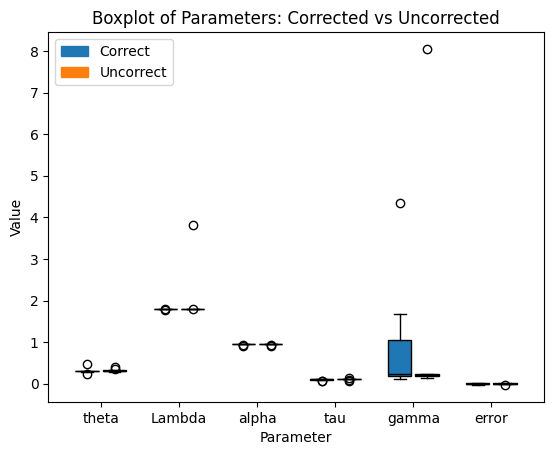

<Figure size 640x480 with 0 Axes>

In [ ]:
from matplotlib.patches import Patch

params_to_plot = ['theta', 'Lambda', 'alpha', 'tau', 'gamma', 'error']

# Prepare data for boxplot
data = [
    params_stan[params_to_plot].values,
    params_MLS[params_to_plot].values
]
 
# Create positions for the boxplots
positions = np.arange(len(params_to_plot))
width = 0.35

# Stan boxplots
plt.boxplot(data[0], positions=positions - width/2, widths=0.3, patch_artist=True, boxprops=dict(facecolor='C0'), medianprops=dict(color='black'), labels=params_to_plot)
plt.boxplot(data[1], positions=positions + width/2, widths=0.3, patch_artist=True, boxprops=dict(facecolor='C1'), medianprops=dict(color='black'))
plt.xticks(positions, params_to_plot)

plt.xlabel('Parameter')
plt.ylabel('Value')
plt.title('Boxplot of Parameters: Corrected vs Uncorrected')

# Add manual legend
stan_patch = Patch(color='C0', label='Correct')
mls_patch = Patch(color='C1', label='Uncorrect')
plt.legend(handles=[stan_patch, mls_patch])

plt.show()

plt.savefig('boxplot.png', dpi=300, bbox_inches='tight')

/var/folders/73/99zh84sx6gx2kqgq02_rm3zh0000gp/T/ipykernel_47769/3121457440.py:40: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


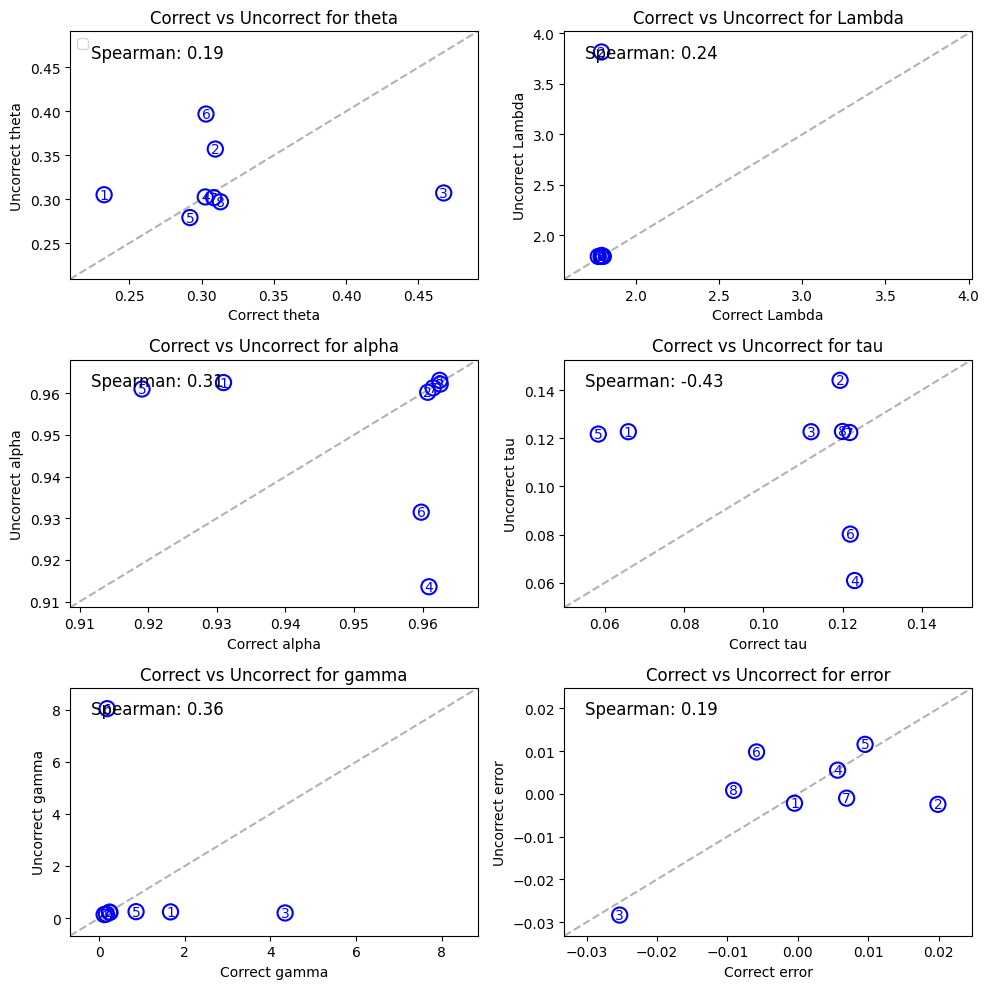

<Figure size 640x480 with 0 Axes>

In [ ]:
# Get mask for subjects with Stan AUC <= 0.5
bad_subjects = auc_results.index[auc_results['roc_auc_stan'] > 0.5]
plt.figure(figsize=(10, 10))


for i, param in enumerate(params_to_plot):
    for idx, (x_val, y_val) in enumerate(zip(params_MLS[param], params_stan[param])):
        plt.subplot(3, 2, i + 1)
        # Draw empty circle
        plt.scatter(y_val, x_val, s=120, facecolors='none', edgecolors='blue', linewidths=1.5, zorder=2)
        # Place subject number (idx+1) inside the circle
        plt.text(y_val, x_val, str(idx + 1), fontsize=10, color='blue', ha='center', va='center', zorder=3)
        # plt.text(y_val, x_val, str(idx + 1), fontsize=9, color='black', ha='right', va='bottom')
    x = params_stan[param]
    y = params_MLS[param]
    # plt.scatter(y, x, alpha=0.7, color='blue')  # invert axes

    # # Highlight in red where Stan AUC <= 0.5
    # mask_bad = params_stan['subject'].isin(bad_subjects)
    # plt.scatter(y[mask_bad], x[mask_bad], color='blue', alpha=0.8)

    plt.xlabel(f'Correct {param}')
    plt.ylabel(f'Uncorrect {param}')
    plt.title(f'Correct vs Uncorrect for {param}')
    
    # Calculate Spearman correlation
    spearman_corr = x.corr(y, method='spearman')
    plt.text(0.05, 0.95, f'Spearman: {spearman_corr:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
    
    # Set equal axis range with 10% margin
    min_val = min(x.min(), y.min())
    max_val = max(x.max(), y.max())
    data_range = max_val - min_val
    margin = 0.1 * data_range
    plt.xlim(min_val - margin, max_val + margin)
    plt.ylim(min_val - margin, max_val + margin)
    plt.plot([min_val - margin, max_val + margin], [min_val - margin, max_val + margin], 'k--', alpha=0.3)

    if i == 0:
        plt.legend()

plt.tight_layout()
plt.show()


plt.savefig('scatter.png', dpi=300, bbox_inches='tight')

In [18]:
auc_results

,roc_auc_stan,roc_auc_MLS,stan_time,MLS_time
f9a528a4-cd95-47cd-af5d-fd7488fa2f5f,0.5,0.5,NaN,NaN
8374ce52-07eb-4861-a570-7d92355dbb9a,0.5,0.5,NaN,NaN
13785ad5-8555-462f-9207-e9038cd838a2,0.5,0.5,NaN,NaN
781f10e6-4241-46bb-a233-43d993723633,0.5,0.5,NaN,NaN
bf5cdead-3fa0-468a-86a6-f29b1c4d0665,0.5,0.5,NaN,NaN
2fbb0673-a652-4c22-9d56-67076478a32e,0.5,0.5,NaN,NaN
07bbb566-d0e4-4582-ab6a-28d93e7ab47f,0.5,0.5,NaN,NaN
2f1c79ff-1730-45f9-a0c7-04d071d4d3b1,0.5,0.5,NaN,NaN
